## dog-breed-identification 
大赛地址：https://www.kaggle.com/c/dog-breed-identification/

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "data/dog-breed-identification/"
sz=224
arch=resnet152
bs=32

数据探索

In [4]:
!ls {PATH}

labels.csv	models			   test      tmp    train.zip
labels.csv.zip	sample_submission.csv.zip  test.zip  train


In [5]:
label_csv = f'{PATH}labels.csv'
label_df = pd.read_csv(label_csv)

In [6]:
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [7]:
# 总共120种。
label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)[:10]

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


In [8]:
# 总共120种。
label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=True)[:10]

,id
breed,
briard,66
eskimo_dog,66
komondor,67
brabancon_griffon,67
golden_retriever,67
german_shepherd,69
walker_hound,69
giant_schnauzer,69
tibetan_mastiff,69


In [9]:
label_df.shape
# 我这边选择1%的作为评价就好了，怎么选择%1呢？总共120种，最多的126，最少的66，所以每一样选择一个作为验证集吧。

(10222, 2)

In [10]:
sample_ids = label_df.pivot_table(index='breed',values='id',aggfunc=lambda x:x.head(1))
sample_ids.head()

,id
breed,
affenpinscher,00ca18751837cd6a22813f8e221f7819
afghan_hound,0379145880ad3978f9b80f0dc2c03fba
african_hunting_dog,00792e341f3c6eb33663e415d0715370
airedale,0267c5f1acbab52ae4a7927e0398612b
american_staffordshire_terrier,02f3d5fd1eea0a2e6f4742bc54b51ba9


In [11]:
val_idxs = label_df[label_df['id'].isin(sample_ids['id'])].index.tolist()

In [12]:
??get_cv_idxs

下面开始一些更深入的数据探索

In [13]:
tfms = tfms_from_model(arch, 
                       sz, 
                       aug_tfms=transforms_side_on, 
                       max_zoom=1.1)

In [14]:
data = ImageClassifierData.from_csv(PATH, 'train' ,f'{PATH}labels.csv', 
                                    test_name='test', val_idxs=val_idxs, suffix='.jpg', 
                                    tfms=tfms, bs=bs)

In [15]:
fn = PATH + data.trn_ds.fnames[0];fn

'data/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg'

In [16]:
label_df[label_df['id']=='00290d3e1fdd27226ba27a8ce248ce85']

,id,breed
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier


In [17]:
data.classes[data.trn_y[0]]

'bedlington_terrier'

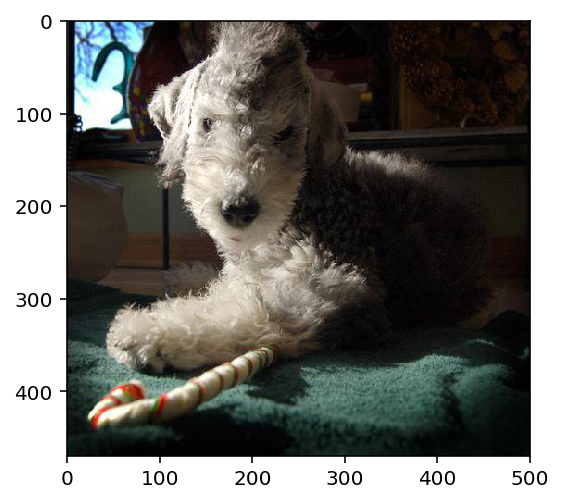

In [18]:
img = plt.imread(PATH + data.trn_ds.fnames[0])
plt.imshow(img);

In [19]:
PIL.Image.open(PATH + data.trn_ds.fnames[0]).size

(500, 470)

下面我们看下数据增强后的效果

In [36]:
tfms_top_down = tfms_from_model(arch, 
                       sz, 
                       aug_tfms=transforms_top_down, # 旋转
                       max_zoom=1.1)
tfms_side_on = tfms_from_model(arch, 
                       sz, 
                       aug_tfms=transforms_side_on, # 旋转
                       max_zoom=1.1)
def get_augs(tfms):
    data = ImageClassifierData.from_csv(PATH, 'train' ,f'{PATH}labels.csv', 
                                    test_name='test', val_idxs=val_idxs, suffix='.jpg', 
                                    tfms=tfms, bs=2)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

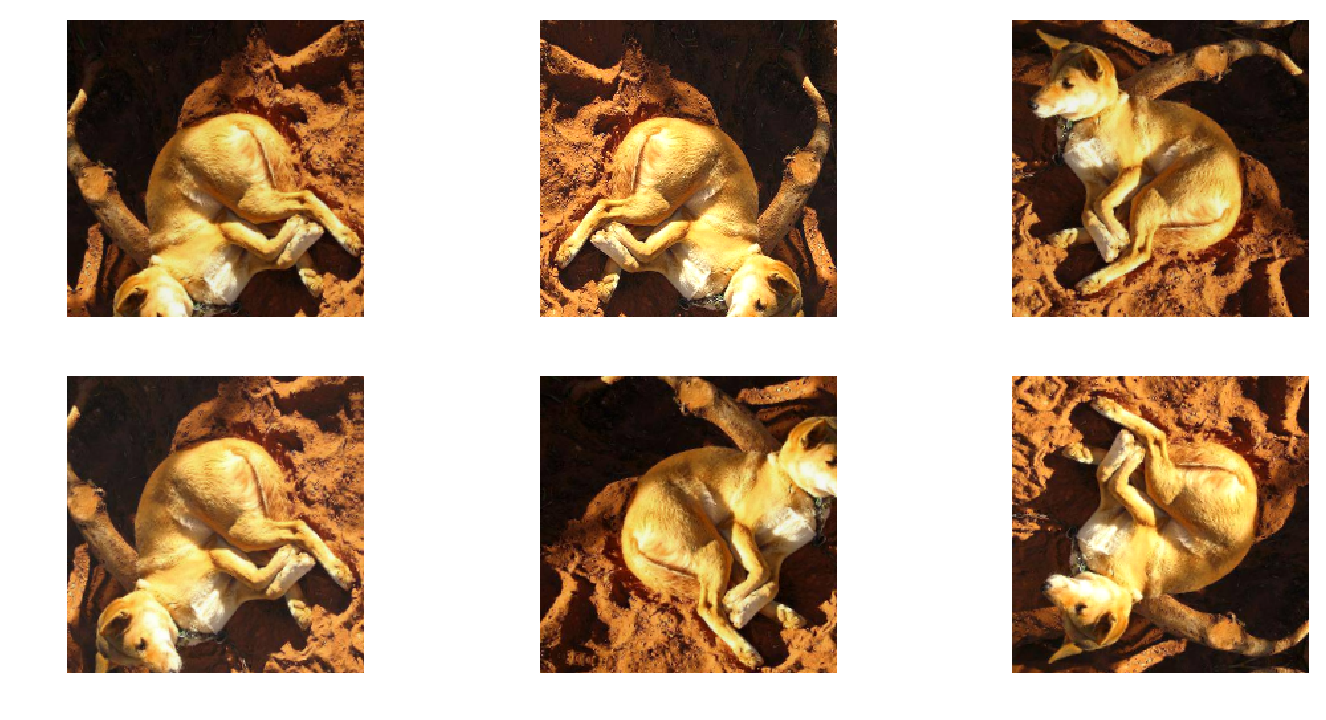

In [37]:
ims = np.stack([get_augs(tfms_top_down) for i in range(6)])
plots(ims, rows=2)

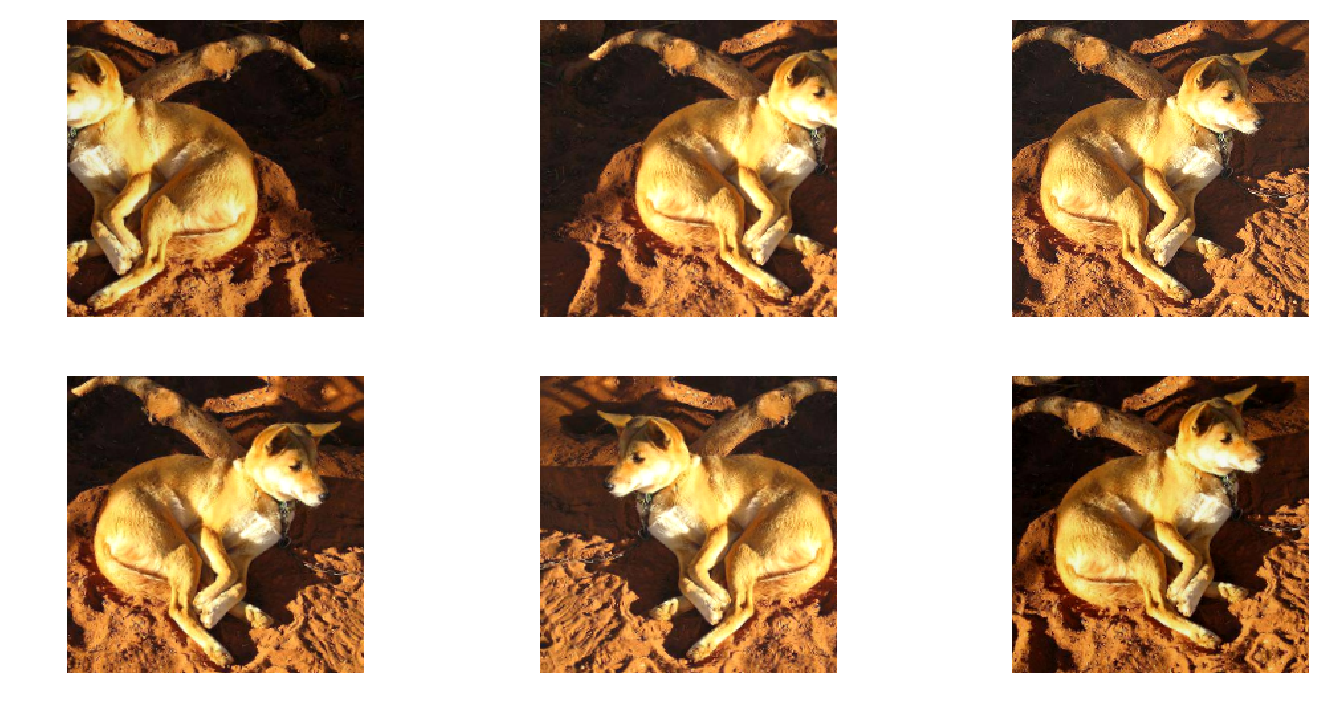

In [40]:
ims = np.stack([get_augs(tfms_side_on) for i in range(6)])
plots(ims, rows=2)

下面我们对所有的图片大小做个统计

In [23]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [24]:
row_sz, col_sz = list(zip(*size_d.values()));
row_sz = np.array(row_sz); col_sz=np.array(col_sz)

(array([3745., 6196.,  106.,   18.,    9.,    4.,   19.,    2.,    1.,    2.]),
 array([  97. ,  413.7,  730.4, 1047.1, 1363.8, 1680.5, 1997.2, 2313.9, 2630.6, 2947.3, 3264. ]),
 <a list of 10 Patch objects>)

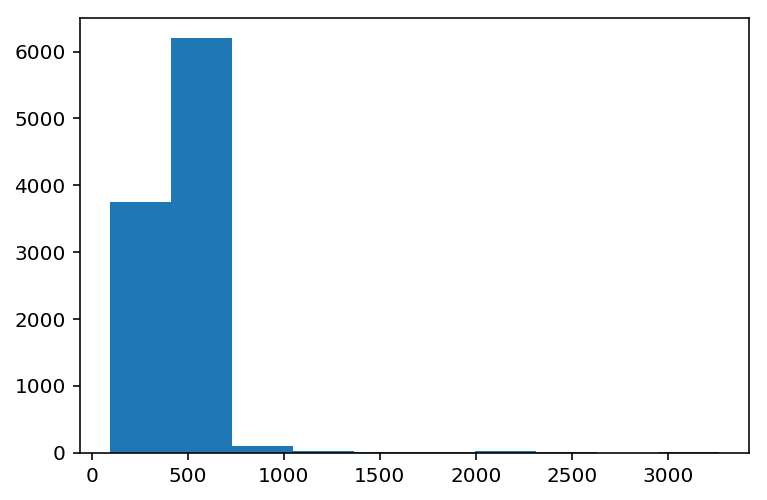

In [25]:
# 先看下行大小
plt.hist(row_sz)

(array([ 175.,  753., 1650., 1464., 5646.,  153.,   98.,   70.,   15.,   12.]),
 array([ 97. , 186.3, 275.6, 364.9, 454.2, 543.5, 632.8, 722.1, 811.4, 900.7, 990. ]),
 <a list of 10 Patch objects>)

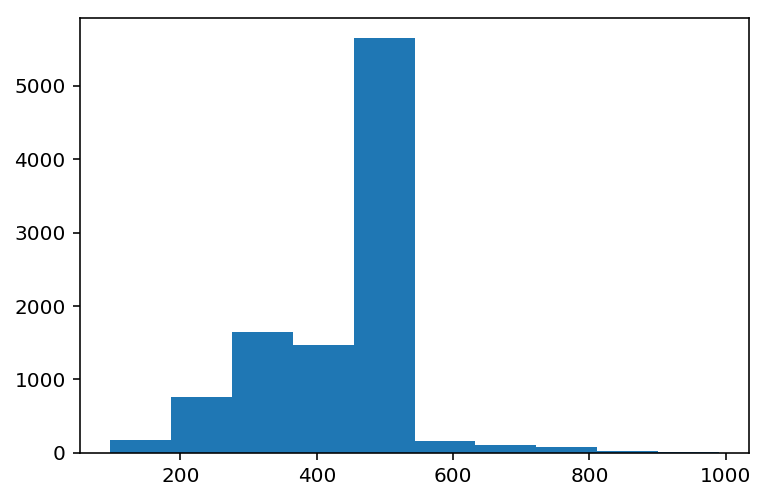

In [26]:
# 绝大多数都是小于1000的
plt.hist(row_sz[row_sz<1000]) 
# 大多数都是在500

(array([3553., 6319.,  150.,   28.,   16.,   20.,   10.,    3.,    0.,    3.]),
 array([ 102.,  348.,  594.,  840., 1086., 1332., 1578., 1824., 2070., 2316., 2562.]),
 <a list of 10 Patch objects>)

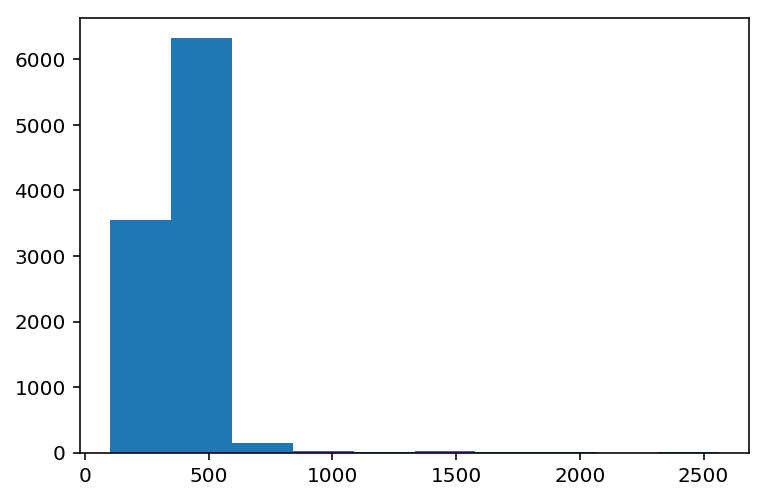

In [27]:
# 列大小
plt.hist(col_sz)

(array([ 297.,  901., 2744., 3653., 2238.,  115.,   33.,   39.,    9.,   11.]),
 array([102. , 190.2, 278.4, 366.6, 454.8, 543. , 631.2, 719.4, 807.6, 895.8, 984. ]),
 <a list of 10 Patch objects>)

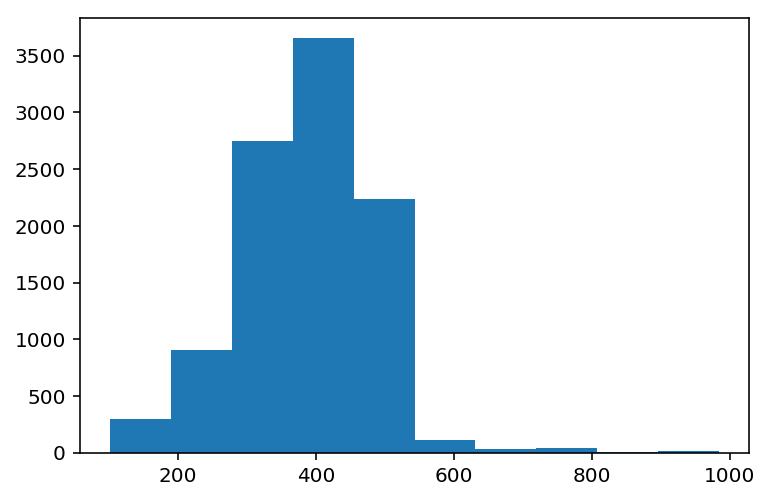

In [28]:
plt.hist(col_sz[col_sz<1000])
# 大多数400

In [29]:
len(data.trn_ds), len(data.test_ds)

(10102, 10357)

In [30]:
len(data.classes), data.classes[:5]

(120,
 ['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier'])

## 训练步骤
1. 开始数据增强功能，设置precompute=True
2. 使用 lr_find() 方法来寻找最大的 learning rate，在此 lr 下，还能显著的降低 loss
3. 使用预训练的模型来训练模型最后一层，大概 1-2 epoches
4. 使用lr变化的方法来训练最后一层，大概 2-3 epoches
5. 解锁所有卷积层
6. 通过 differential learning rates 来训练网络
7. 再次使用 lr_find()
8. 设置 cycle_mult=2 再次训练整个网络，直到过拟合

In [43]:
# 1. 开启数据增加功能
sz = 224 # 500，因为上面分析图片大多数都是这个大小，但是使用500计算量大。效果还不佳
bs = 32
arch = resnet152
data = ImageClassifierData.from_csv(PATH, 'train' ,f'{PATH}labels.csv', 
                                    test_name='test', val_idxs=val_idxs, suffix='.jpg', 
                                    tfms=tfms_top_down, bs=bs)

In [44]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [45]:
# 找到最佳 lr
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▍ | 267/316 [00:06<00:01, 41.28it/s, loss=8.41]


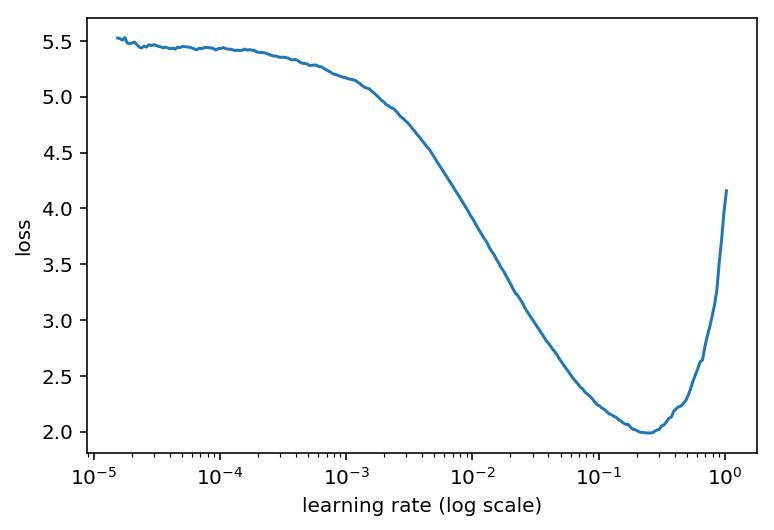

In [46]:
learn.sched.plot()

上面我们可以取 lr = 0.01

3. 使用预训练的模型来训练模型最后一层，大概 1-2 epoches

In [47]:
learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.682473   0.459973   0.848958  
    1      0.450233   0.310403   0.895833                    



[0.31040323, 0.8958333283662796]

4.使用 lr 变化的方法来训练最后一层，大概 2-3 epoches

In [48]:
# 看到比较好的还是0.01
learn.precompute=False

In [49]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.528049   0.288063   0.90625   
    1      1.410644   0.278517   0.929688                   
    2      1.322292   0.285273   0.903646                   



[0.2852725, 0.9036458283662796]

5.解锁所有卷积层

6.通过 differential learning rates 来训练网络

In [50]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

# 可以说效果太差了。

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.164292   0.382395   0.890625  
    1      1.063156   0.405791   0.864583                   
    2      0.808166   0.358986   0.856771                    
 67%|██████▋   | 211/316 [02:03<01:01,  1.71it/s, loss=0.929]

KeyboardInterrupt: 

In [ ]:
# 效果不佳。我感觉原因是因为我选取的 val_set 有问题，得重新选。

In [ ]:
lrf=learn.lr_find()
learn.sched.plot()

我们发现好像找不到很好的学习率了。从上面整个过程来看，似乎训练之前的网络没有什么作用。还不如一直训练最后

In [ ]:
# 1. 开启数据增加功能
sz = 224
bs = 32
# arch = resnet34
arch = resnet152
tfms = tfms_from_model(arch, 
                       sz, 
                       aug_tfms=transforms_side_on, 
                       max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train' ,f'{PATH}labels.csv', 
                                    test_name='test', val_idxs=val_idxs, suffix='.jpg', 
                                    tfms=tfms, bs=bs)

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [ ]:
# 找到最佳 lr
lrf=learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
learn.fit(1e-2, 2)

In [ ]:
lrf=learn.lr_find()
learn.sched.plot()

In [ ]:
learn.fit(1e-2, 2)

In [ ]:
learn.fit(1e-2, 2)

In [ ]:
learn.precompute=False

In [ ]:
log_preds = learn.predict()

In [ ]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1

In [ ]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))        

In [ ]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, data.val_y)

In [ ]:
log_preds = learn.predict()
accuracy_np(probs, data.val_y)

In [ ]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]